<img src="https://i.imgur.com/12tfKrD.png" alt="Alin">
</img>


# Demo RNN -- 張愛玲散文集AI二次創作

資料集: 張愛玲繁體中文小說 《傳奇》

爬蟲來源: [crawl_book](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)

程式碼參考: [Tensorflow](https://www.tensorflow.org/tutorials/text/text_generation)

本次資料集，著作權乃是張愛玲女士所擁有。**請勿將本次資料集散播、更改、用於非商業用途**。

> **資料集說明**

今年是張愛玲女士101年誕辰。張愛玲出生名門，曾就讀於香港大學和聖約翰大學，受過良好的中西教育。上海淪陷時期，陸續發表《沉香屑·第一爐香》、《傾城之戀》、《心經》、《金鎖記》等中、短篇小說，震動上海文壇。

這次訓練取張愛玲散文集《傳奇》作為訓練，《傳奇》收留五篇散文: 「留情」、「鴻鸞禧」、「紅玫瑰與白玫瑰」、「等」、「桂花蒸阿小悲秋」。其中以「紅玫瑰與白玫瑰」最為膾炙人口。

> **訓練步驟**

深度學習在訓練模型上有以下幾個重要的步驟:
1. 讀入相關封包
2. 取得資料集 
3. 資料前處理
4. 建立模型
5. 制定訓練計畫
6. 評估模型
7. 做預測

> **本次模型介紹 RNN**

![](https://i.imgur.com/FaY50C8.png)


我們來看看維度，很多人會搞不懂RNN的維度:

一個Seq通過RNN後的維度

* Input: (Seq,${originDim}$)
* RNN Neuron: 2048
* Output: (Seq,2048) if (return_sequence == True) else (1,2048)
![](https://i.imgur.com/9SVl6JR.png)

![](https://i.imgur.com/z4ElFIr.png)

**把生成問題變成分類問題**

![](https://i.imgur.com/TBHKuf6.png)


In [ ]:
# ****************************************
# **請勿將本次資料集散播、用於非商業用途**
# ****************************************

# 執行即代表同意將會合法、合理使用資料集

!wget -O Eileen_Legendary.txt "http://140.115.82.54/NN/Recurrent/Eileen_Legendary.txt"

## 1. 讀入Package

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt

## 2. 取得資料集

In [ ]:
# 作業之一就是試試看其他本小說

book = ""
with open("/content/Qiong Yao.txt","r",encoding="utf8") as file:
  for line in file:
    book += line

book_length = len(book)
unique_words = set(book)
print(f"瓊瑤煙雨濛濛共有 {book_length} 字詞")
print(f"包含了 {len(unique_words)} 個獨一無二的字 (含標點符號)\n")
print(book[0:500])

瓊瑤煙雨濛濛共有 157411 字詞
包含了 2815 個獨一無二的字 (含標點符號)


《二○一六年十一月四日版》
《好讀書櫃》經典版
第一章
又到了這可厭的日子，吃過了晚飯，我悶悶的坐在窗前的椅子裡，望著窗外那綿綿密密的細雨。屋檐下垂著的電線上，掛著一串水珠，晶瑩而透明，像一條珍珠項鍊。在那圍牆旁邊的芭蕉樹上，水滴正從那闊大的葉片上滾下來，一滴又一滴，單調而持續的滾落在泥地上。圍牆外面，一盞街燈在細雨裡高高的站著，漠然的放射著它那昏黃的光線，那麼的孤高和驕傲，好像全世界上的事與它無關似的。本來嘛，世界上的事與它又有什麼關係呢？我嘆了口氣，從椅子裡站了起來，無論如何，我該去辦自己的事了。
「依萍，你還沒有去嗎？」
媽從廚房裡跑了出來，她剛剛洗過碗，手上的水還沒有擦乾，那條藍色滾白邊的圍裙也還繫在她的腰上。
「我就要去了。」我無可奈何的說，在屋角裡找尋我的雨傘。
「到了『那邊』，不要和他們起衝突才好，告訴你爸爸，房租不能再拖了，我們已經欠了兩個月──」
「我知道，不管用什麼方法，我把錢要來就是了！」我說，仍然在找尋我的傘。
「你的傘在壁櫥裡。」媽說，從壁櫥裡拿出了我的傘，交給了我，又望了望天，低聲的說：「早一點回來，如果拿到了錢，就坐三輪車回來吧！雨要下大了。」
我拿著傘


## 3. 資料前處理

文字前處理有一堆方法、作法:
* 切字
* 還原
* 清除特殊字符
* 清除不常見字符 (StopWord)


我這裡僅使用去除不常見的字(StopWord)

In [ ]:
# 計算字數統計
words_count = {}
for w in book:
  if w in words_count:
    words_count[w] += 1
  else:
    words_count[w] = 1

words_count = sorted(words_count.items(),key=lambda x:x[1])

In [ ]:
stop_word = 8
unique_words = [w_tup[0] for w_tup in words_count if w_tup[1]>stop_word]
print(f"去除次數小於{stop_word}的文字剩餘 : {len(unique_words)}")

去除次數小於8的文字剩餘 : 1331


In [ ]:
print(f"原本煙雨濛濛共有 {book_length} 字詞")
print(f"去除不常出現的文字後")
book = [w for w in book if w in unique_words]
print(f"剩餘{len(book)}個字")

原本煙雨濛濛共有 157411 字詞
去除不常出現的文字後
剩餘152829個字


In [ ]:
# 文字轉數字(index)
word_2_index = {word:index for index,word in enumerate(unique_words)}
index_2_word = {word_2_index[word]:word for word in word_2_index}

book_2_index = [word_2_index[w] for w in book]

print("原始文字 : ")
print(book[:40])
print("-"*40)
print("轉成index : ")
print({word_2_index[w] for w in book[:40]})

原始文字 : 
['\n', '《', '二', '一', '六', '年', '十', '一', '月', '四', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經', '版', '\n', '第', '一', '\n', '又', '到', '了', '這', '可', '厭', '的', '日', '子', '，', '吃', '過', '了', '晚']
----------------------------------------
轉成index : 
{1282, 1158, 1033, 1292, 1167, 1301, 1305, 539, 1307, 1060, 293, 938, 1322, 1326, 687, 688, 1327, 1328, 1330, 1209, 196, 197, 1094, 332, 983, 1004, 1262, 1139, 1268, 1276}


In [ ]:
def ind2word_seq(seq):
  return [index_2_word[i] for i in seq]

In [ ]:
# 設定輸入模型長度
seq_len = 20
characters = tf.data.Dataset.from_tensor_slices(book_2_index)
# characters = characters.map(lambda w:word_2_index[w.item()])

sequences = characters.batch(seq_len+1,drop_remainder=True)

for seq in sequences.take(2):
  print(seq.shape)
  print(seq)
  print([index_2_word[i] for i in seq.numpy()])

(21,)
tf.Tensor(
[1326  687  938 1322  539 1167 1158 1322 1060 1033 1139  196  688 1326
  687 1276  197 1292  332  688 1209], shape=(21,), dtype=int32)
['\n', '《', '二', '一', '六', '年', '十', '一', '月', '四', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經']
(21,)
tf.Tensor(
[ 196 1326  983 1322 1326 1268 1305 1327 1307 1262  293 1328 1139 1301
 1330 1094 1282 1327 1004  753 1330], shape=(21,), dtype=int32)
['版', '\n', '第', '一', '\n', '又', '到', '了', '這', '可', '厭', '的', '日', '子', '，', '吃', '過', '了', '晚', '飯', '，']


![](https://i.imgur.com/YMVMFEJ.png)


In [ ]:
# 做input、target切割
def split_input_target(seq):
  input_txt = seq[:-1]
  target_txt = seq[1:]
  return input_txt,target_txt

split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

![](https://i.imgur.com/YoHWLkf.png)


In [ ]:
dataset = sequences.map(split_input_target)

for input_example,target_exaple in dataset.take(1):
  print("Input :", ind2word_seq(input_example.numpy()))
  print("Target:", ind2word_seq(target_exaple.numpy()))
  print("-"*50)
  print("Input :", input_example.numpy())
  print("Target:", target_exaple.numpy())

Input : ['\n', '《', '二', '一', '六', '年', '十', '一', '月', '四', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》']
Target: ['《', '二', '一', '六', '年', '十', '一', '月', '四', '日', '版', '》', '\n', '《', '好', '讀', '書', '櫃', '》', '經']
--------------------------------------------------
Input : [1326  687  938 1322  539 1167 1158 1322 1060 1033 1139  196  688 1326
  687 1276  197 1292  332  688]
Target: [ 687  938 1322  539 1167 1158 1322 1060 1033 1139  196  688 1326  687
 1276  197 1292  332  688 1209]


In [ ]:
# 建立資料集
# Batch size
BATCH_SIZE = 64

BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True))

dataset

<BatchDataset shapes: ((64, 20), (64, 20)), types: (tf.int32, tf.int32)>

## 4. 建立模型

![](https://i.imgur.com/TBHKuf6.png)

In [ ]:
# 超參數
EMBEDDING_DIM = 512

# 使用 keras 建立一個非常簡單的 LSTM 模型
model = tf.keras.Sequential()

model.add(
  tf.keras.layers.Embedding(
    input_dim=len(unique_words), 
    output_dim=EMBEDDING_DIM
))

model.add(
  tf.keras.layers.LSTM(
    units=4096, 
    return_sequences=True, 
))

model.add(
  tf.keras.layers.LSTM(
    units=2048, 
    return_sequences=True,
))
  
model.add(
  tf.keras.layers.Dense(
      len(unique_words),activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 512)         681472    
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 4096)        75513856  
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 2048)        50339840  
_________________________________________________________________
dense_1 (Dense)              (None, None, 1331)        2727219   
Total params: 129,262,387
Trainable params: 129,262,387
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 查看模型的輸入、輸出 shape
for input_example,target_exaple in dataset.take(1):
  predict_example = model(input_example)
  print(f"Model input shape : {input_example.shape}")
  print(f"Model output shape : {predict_example.shape}")
  print(f"Model target shape : {target_exaple.shape}")

Model input shape : (64, 20)
Model output shape : (64, 20, 1331)
Model target shape : (64, 20)


In [ ]:
print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入尚未訓練的model後獲得：")
print()

predict_words = tf.math.argmax(predict_example[0],-1)
[print(index_2_word[ind],end="") for ind in predict_words.numpy()]
print()

原本的中文字序列：
了，謝謝老天！」她興奮的去端那杯牛，又要
----------------------------------------
輸入尚未訓練的model後獲得：

秘蹙蹙蹙眉眉拚挨眉由由由修修修顯顯顯拚取


## 5. 制定訓練計畫並訓練

* [sparse_categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy) V.S. [categorical_crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/categorical_crossentropy)

```python=
# categorical_crossentropy
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

# sparse_categorical_crossentropy
y_true = [1, 2]
y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]
assert loss.shape == (2,)

```


In [ ]:
model.compile(loss="sparse_categorical_crossentropy",optimizer="adam")

In [ ]:
EPOCHS = 20
history = model.fit(
    dataset, # 前面使用 tf.data 建構的資料集
    epochs=EPOCHS,
)

Epoch 1/20
113/113 [==============================] - 40s 328ms/step - loss: 6.1959
Epoch 2/20
113/113 [==============================] - 39s 342ms/step - loss: 5.3163
Epoch 3/20
113/113 [==============================] - 41s 358ms/step - loss: 4.5809
Epoch 4/20
113/113 [==============================] - 42s 366ms/step - loss: 4.0697
Epoch 5/20
113/113 [==============================] - 41s 365ms/step - loss: 3.7171
Epoch 6/20
113/113 [==============================] - 43s 376ms/step - loss: 3.4025
Epoch 7/20
113/113 [==============================] - 43s 378ms/step - loss: 3.0290
Epoch 8/20
113/113 [==============================] - 43s 380ms/step - loss: 2.5888
Epoch 9/20
113/113 [==============================] - 43s 383ms/step - loss: 2.0344
Epoch 10/20
113/113 [==============================] - 43s 383ms/step - loss: 1.4265
Epoch 11/20
113/113 [==============================] - 43s 380ms/step - loss: 0.8948
Epoch 12/20
113/113 [==============================] - 43s 381ms/step - lo

## 6. 衡量模型

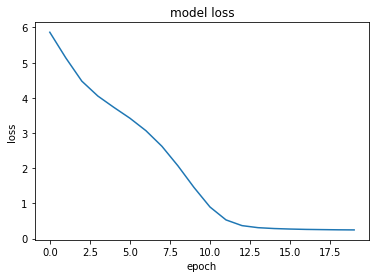

In [ ]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
after_train_predictions = model(input_example)
after_sampled_indices = tf.argmax(after_train_predictions[0],1)

print("原本的中文字序列：")
[print(index_2_word[ind],end="") for ind in input_example[0].numpy()]
print()
print("-"*40)
print("輸入進訓練後的model後獲得：")
print()

[print(index_2_word[ind],end="") for ind in after_sampled_indices.numpy()]
print()

原本的中文字序列：
了，謝謝老天！」她興奮的去端那杯牛，又要
----------------------------------------
輸入進訓練後的model後獲得：

，他謝老天！」她興奮的去端那杯牛，又要笑


## 7. 做預測

![](https://i.imgur.com/YsOj6Mw.png)

在實際生成文字時，我們會想要增加一些隨機性。比如”天天出去” 不加入隨機 “天天天天” 如果我們全部輸出的字都是取softmax最大可能性，則一個訓練完美的model會把整本書給輸出出來。但是我們要的是，希望電腦在最大可能性的幾個字中隨機挑選一個字出來。

tf.random.categorical 會根據softmax機率後隨機挑選字，但是我們不希望因為模型很爛導致不合理的字被選中，因此我們會除上一個temperature來增加可能字的比重。

EX: "天天出去" 預測下一個字
1. 玩 : 0.3 
2. 天 : 0.1 
3. 浪 : 0.4 

"天"有的機率被印出，我們不希望。所以我們可以在每一個機率除上一個temperature(0.01)
1. 玩 : 30 
2. 天 : 10 
3. 浪 : 40 
原本"浪"跟"天"差0.3，除temperature後差30



In [ ]:
# 預測文字，並把預測文字循環當作下一次的輸入

# 設定你的temperature
temperature = 0.01

def generateWords(input,words=500):
  [print(index_2_word[ind],end="") for ind in input]
  for i in range(words):
    next_input = tf.expand_dims(input,axis=0)
    predicts = model(next_input)
    predicts = predicts[:,-1,:]
    predicts /= temperature
    result = tf.random.categorical(
        predicts,num_samples=1
    )
    chinese_ind = tf.squeeze(result).numpy()
    print(index_2_word[chinese_ind],end="")
    input = input+[chinese_ind]
    input = input[-seq_len:]

In [ ]:
init_seq = "煙雨濛濛"
init_seq_ind = [word_2_index[w] for w in init_seq]
input = init_seq_ind[-seq_len:]

generateWords(input,500)

煙雨濛濛的走了出去。我在客廳裡坐了下來，立即，四週之後，我們才能吐出一口氣。
書桓在我身邊，我轉過頭，看到我回頭。她扭著身子，露出一口煙和惶惑的，又又一次又一次。這時，我們的同學，只是我們喪中都是個鬼，可是，我腦子中越來越沉重，幾次越氣越氣，氣不得像一個我的。爸爸，他在我的眼前和仇恨他的東西，是個望見的！」
「我想先查媽，」我說：「我一點都沒有不寧了。」
「你懷疑我──」雪姨大聲的喊。
「那麼，你幫我去就是我，我是個沒有人性的女兒！」
「雪姨！」爸爸興奮的插了進來說：「你想要！我要讓你死！」
「我不是！」他們繼續走了一段，方瑜說：「你是不是需要一個助理？」
「我不做你！」他笑著說：「我也不知道你來了，你要我們一起，給我一個意外！」
「你是嗎？」我有點氣憤：「你認為我是個危嗎？」
「是的，在金錢方面很貧窮，在人母親，」在一個小包車前面，我的手從沙發中抬起來，他的眼睛哀傷而淒苦。我望著他，於是，他又張開眼睛來看看我，低聲的說：「你再多說也沒用，你要就把錢，我不是再在你的腳頭了！」
「哦，我的天！」我嘆口氣。「那麼，你斷定有個外來的共謀犯，是人、夢萍、夢萍、夢萍，我們再重新認識，重新戀愛多好！」這是

In [ ]:
import time
while True:
  time.sleep(5)
  pass

## 作業2.1 (30%)

使用[爬蟲程式](https://colab.research.google.com/drive/1f_HvQEvgkJPFc473TlA-I_3EmkThA2SR?usp=sharing)來取得資料集，或是不管你從哪裡取得的資料集也可以(不要再張愛玲了，不限中英文)。然後丟入這個模型來看看AI生成文字的成果，將**結果**與**你的心得**(不是機器產生的心得)，貼上pdf。

資料集越有趣越好，比如你可以去爬PTT文章來製作廢文產生器。去爬Dcard製作幻想文產生器。